# Librerias

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception, MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, legacy as legacy_optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.keras import TqdmCallback  # Importamos el callback de TQDM
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Clasificación 6 Clases

## Dataset

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import shutil

# Directorio de las imágenes originales
data_dir = 'crops_90x90'

# Directorio de salida para las imágenes divididas en 6 clases
output_dir = 'crops_90x90_6clases'  # Cambiado a 6 clases
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Crear las carpetas de entrenamiento, validación y prueba si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Definir las 6 clases
classes = ['Negative', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC']

# Crear subcarpetas para cada clase dentro de train, val y test
for split_dir in [train_dir, val_dir, test_dir]:
    for class_name in classes:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Configuración del generador de imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargar todas las imágenes y sus etiquetas desde el directorio original
all_images_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='categorical',  # Multiclase
    classes=classes,
    shuffle=False  # No mezclar para mantener la correspondencia entre imágenes y etiquetas
)

# Obtener los paths de los archivos y las etiquetas numéricas
filepaths = all_images_generator.filepaths
labels = all_images_generator.classes  # Etiquetas numéricas

# Obtener el mapeo de índices a nombres de clase
class_indices = all_images_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Crear un DataFrame para facilitar la manipulación de datos
df = pd.DataFrame({
    'filename': filepaths,
    'label': labels
})

# Dividir el dataset en entrenamiento (70%), validación (15%) y prueba (15%)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    df['filename'], df['label'], test_size=0.30, stratify=df['label'], random_state=42
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42
)

# Función para crear enlaces simbólicos a las imágenes en las carpetas correspondientes
def create_symlinks(filepaths, labels, dest_dir, index_to_class):
    for filepath, label in zip(filepaths, labels):
        class_name = index_to_class[label]  # Obtener el nombre de la clase
        dest_subfolder = class_name
        dest_path = os.path.join(dest_dir, dest_subfolder, os.path.basename(filepath))
        
        # Verificar si el enlace ya existe
        if not os.path.exists(dest_path):
            try:
                os.symlink(os.path.abspath(filepath), dest_path)
            except OSError as e:
                print(f"Error al crear el enlace simbólico para {filepath}: {e}")

# Copiar (crear enlaces) las imágenes a las carpetas de entrenamiento, validación y prueba
create_symlinks(train_files, train_labels, train_dir, index_to_class)
create_symlinks(val_files, val_labels, val_dir, index_to_class)
create_symlinks(test_files, test_labels, test_dir, index_to_class)

# Imprimir el resultado de la división
print(f"Total de imágenes en entrenamiento: {len(train_files)}")
print(f"Total de imágenes en validación: {len(val_files)}")
print(f"Total de imágenes en prueba: {len(test_files)}")


Found 11534 images belonging to 6 classes.
Total de imágenes en entrenamiento: 8073
Total de imágenes en validación: 1730
Total de imágenes en prueba: 1731


### Distribución de clases

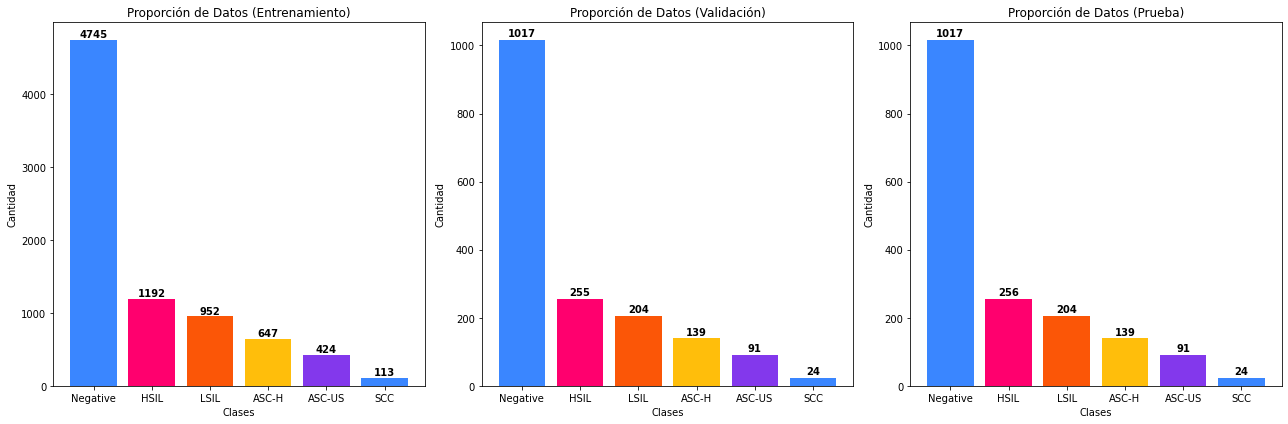

In [6]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Función para contar imágenes en cada clase dentro de una carpeta
def count_images_in_classes(folder_path, classes):
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(folder_path, class_name)
        class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Función para crear gráficos de barras para las proporciones de las 5 clases
def plot_class_proportion_subplot(ax, class_counts, title):
    # Crear el gráfico de barras en el subplot
    ax.bar(class_counts.keys(), class_counts.values(), color=['#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC'])
    ax.set_xlabel('Clases')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    for i, (class_name, count) in enumerate(class_counts.items()):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops_90x90_6clases/train'
val_dir = 'crops_90x90_6clases/val'
test_dir = 'crops_90x90_6clases/test'

# Clases a considerar
classes = ['Negative', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC']

# Contar las imágenes en cada clase para cada conjunto
train_class_counts = count_images_in_classes(train_dir, classes)
val_class_counts = count_images_in_classes(val_dir, classes)
test_class_counts = count_images_in_classes(test_dir, classes)

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_class_proportion_subplot(axes[0], train_class_counts, 'Proporción de Datos (Entrenamiento)')
plot_class_proportion_subplot(axes[1], val_class_counts, 'Proporción de Datos (Validación)')
plot_class_proportion_subplot(axes[2], test_class_counts, 'Proporción de Datos (Prueba)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()


# Modelos

In [7]:
# Configuración de directorios
train_dir = 'crops_90x90_6clases/train'
val_dir = 'crops_90x90_6clases/val'
test_dir = 'crops_90x90_6clases/test'

IMG_HEIGHT, IMG_WIDTH = 90, 90
BATCH_SIZE = 32

# Generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 8073 images belonging to 6 classes.
Found 1730 images belonging to 6 classes.
Found 1731 images belonging to 6 classes.


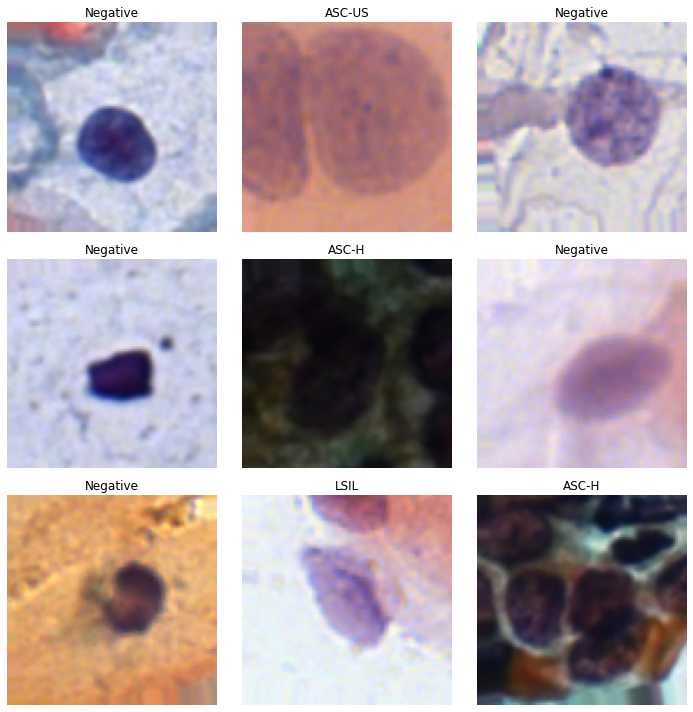

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un lote de imágenes y etiquetas del generador
images, labels = next(train_generator)

# Mapeo de índices de clase a nombres de clase
class_labels = list(train_generator.class_indices.keys())

# Mostrar algunas imágenes del lote
def mostrar_imagenes(images, labels, class_labels, num_imagenes=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_imagenes):
        ax = plt.subplot(3, 3, i + 1)  # 3x3 grid para mostrar 9 imágenes
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])  # Obtener la clase predicha (una-hot encoding)
        plt.title(class_labels[label_index])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Mostrar las imágenes
mostrar_imagenes(images, labels, class_labels)

## Modelo EfficientNetB0

In [ ]:
# Definición del modelo EfficientNetB0
NUM_CLASSES = len(train_generator.class_indices)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Entrenamiento con barra de progreso
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]  # Barra de progreso
)

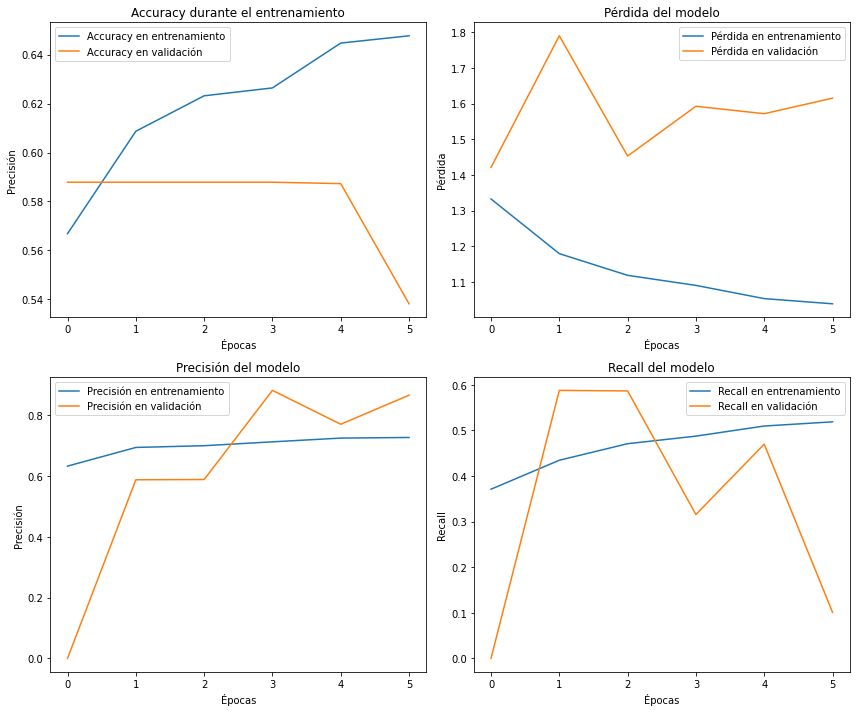

In [9]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [10]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2519 - auc: 0.5406 - f1_score: 0.5406 - loss: 1.9099 - precision: 0.0000e+00 - recall: 0.0000e+00
Pérdida en el conjunto de prueba: 1.4216272830963135
accuracy en el conjunto de prueba: 0.5875216722488403
Precision en el conjunto de prueba: 0.0
Recall en el conjunto de prueba: 0.0
AUC en el conjunto de prueba: 0.7929120063781738
F1-Score en el conjunto de prueba: 0.7929120063781738


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step


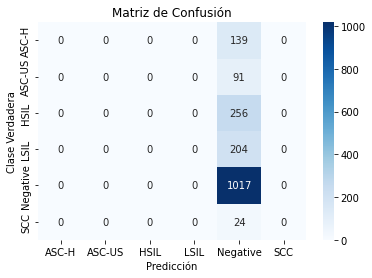

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step


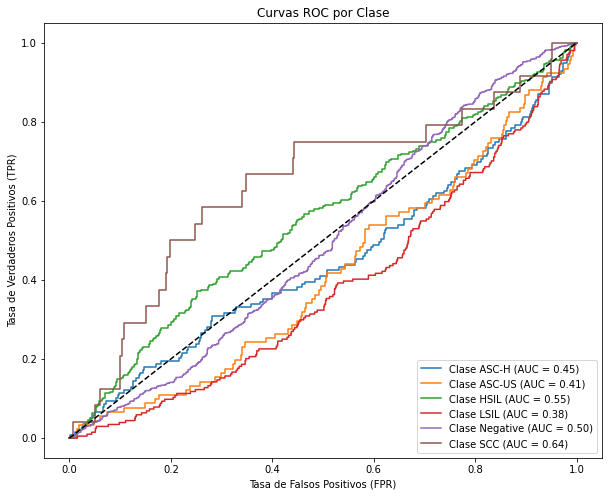

AUC Promedio: 0.49
AUC Promedio Ponderado: 0.48


In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')


## Modelo EfficientNetB4

In [14]:
# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 166s 576ms/step - accuracy: 0.5233 - auc: 0.7897 - f1_score: 0.7897 - loss: 1.3614 - precision: 0.6505 - recall: 0.3196 - val_accuracy: 0.5879 - val_auc: 0.8506 - val_f1_score: 0.8506 - val_loss: 1.2553 - val_precision: 0.5879 - val_recall: 0.5879 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 143s 563ms/step - accuracy: 0.6033 - auc: 0.8667 - f1_score: 0.8667 - loss: 1.1271 - precision: 0.7442 - recall: 0.4554 - val_accuracy: 0.6376 - val_auc: 0.8987 - val_f1_score: 0.8987 - val_loss: 0.9862 - val_precision: 0.8325 - val_recall: 0.4884 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 143s 563ms/step - accuracy: 0.6311 - auc: 0.8866 - f1_score: 0.8866 - loss: 1.0473 - precision: 0.7745 - recall: 0.4745 - val_accuracy: 0.6879 - val_auc: 0.9219 - val_f1_score: 0.9219 - val_loss: 0.8766 - val_precision: 0.8142 - val_recall: 0.5370 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 149s 586ms/s

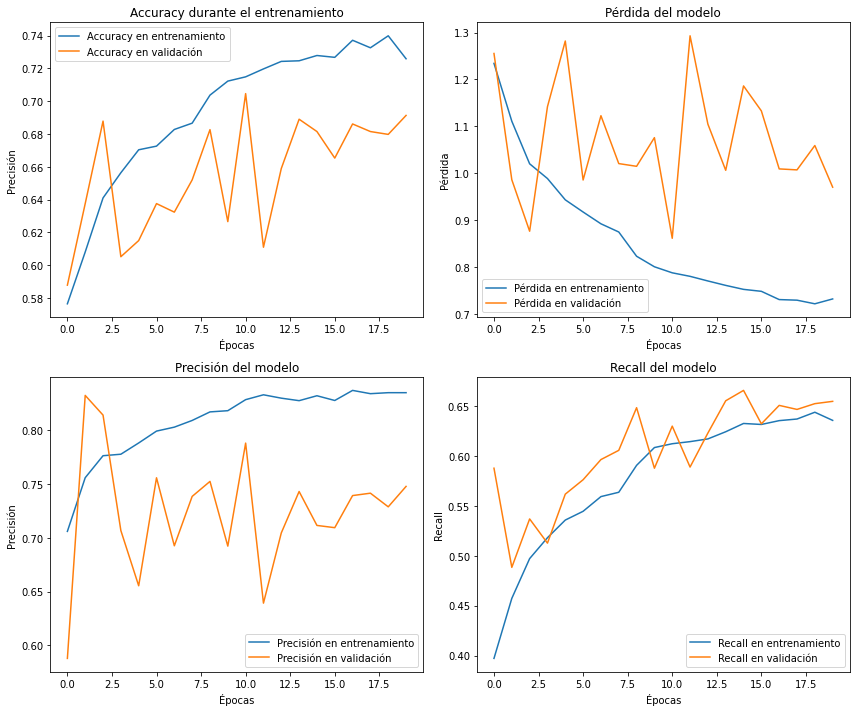

In [15]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [16]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.4628 - auc: 0.7859 - f1_score: 0.7859 - loss: 1.5491 - precision: 0.5009 - recall: 0.3682
Pérdida en el conjunto de prueba: 0.8913264870643616
accuracy en el conjunto de prueba: 0.7001733183860779
Precision en el conjunto de prueba: 0.7811614871025085
Recall en el conjunto de prueba: 0.6372039318084717
AUC en el conjunto de prueba: 0.9244027137756348
F1-Score en el conjunto de prueba: 0.9244027137756348


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step


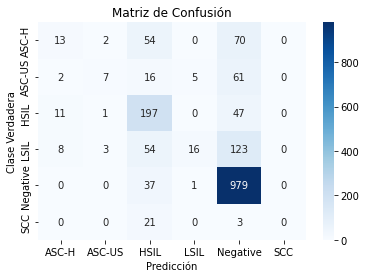

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step


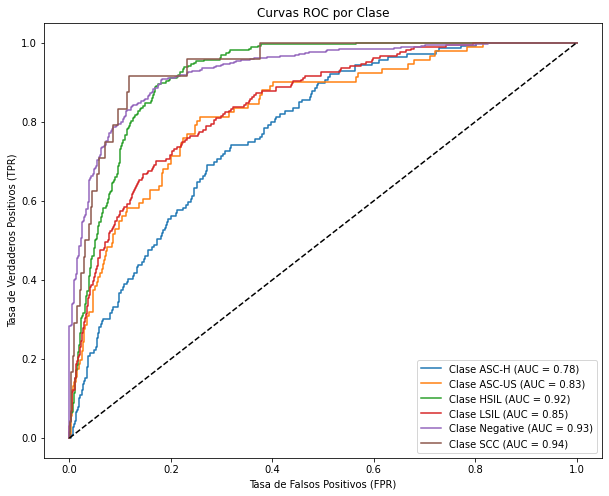

AUC Promedio: 0.87
AUC Promedio Ponderado: 0.90


In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')


## Modelo EfficientNetB5

In [19]:
# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.4827 - auc: 0.7816 - f1_score: 0.7816 - loss: 1.3670 - precision: 0.7692 - recall: 0.2610 - val_accuracy: 0.6260 - val_auc: 0.8948 - val_f1_score: 0.8948 - val_loss: 1.0069 - val_precision: 0.8243 - val_recall: 0.4988 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.6417 - auc: 0.9004 - f1_score: 0.9004 - loss: 0.9841 - precision: 0.8134 - recall: 0.5011 - val_accuracy: 0.7064 - val_auc: 0.9298 - val_f1_score: 0.9298 - val_loss: 0.8382 - val_precision: 0.8325 - val_recall: 0.5832 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 251s 989ms/step - accuracy: 0.6731 - auc: 0.9141 - f1_score: 0.9141 - loss: 0.9170 - precision: 0.8086 - recall: 0.5461 - val_accuracy: 0.7260 - val_auc: 0.9373 - val_f1_score: 0.9373 - val_loss: 0.7849 - val_precision: 0.8403 - val_recall: 0.6116 - learning_rate: 1.0000e-04
Epoc

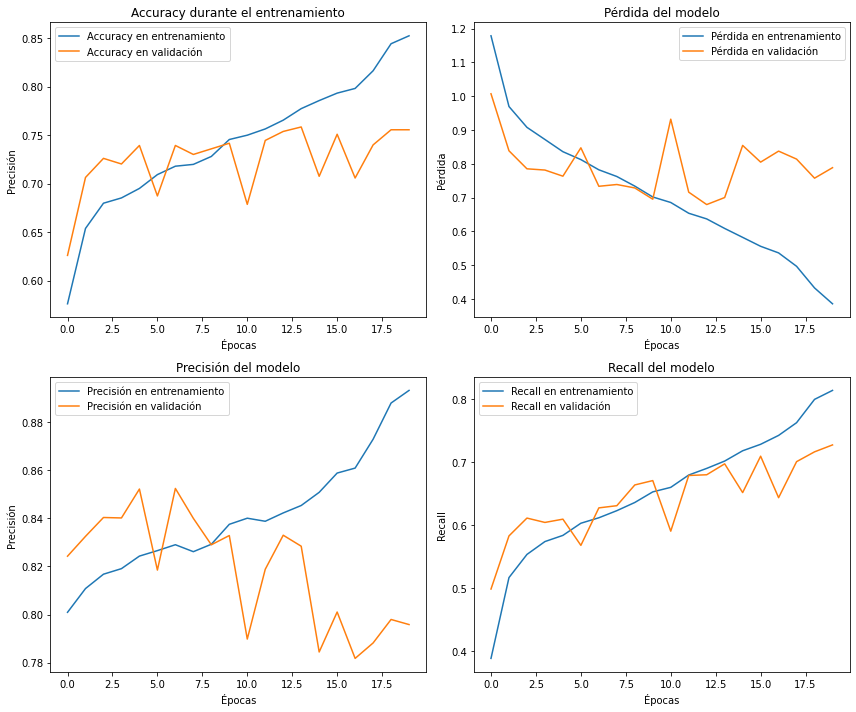

In [25]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [21]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.5610 - auc: 0.8726 - f1_score: 0.8726 - loss: 1.1013 - precision: 0.6134 - recall: 0.4553
Pérdida en el conjunto de prueba: 0.6687554121017456
accuracy en el conjunto de prueba: 0.7596765160560608
Precision en el conjunto de prueba: 0.8312146663665771
Recall en el conjunto de prueba: 0.6799538135528564
AUC en el conjunto de prueba: 0.9547063708305359
F1-Score en el conjunto de prueba: 0.9547063708305359


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step


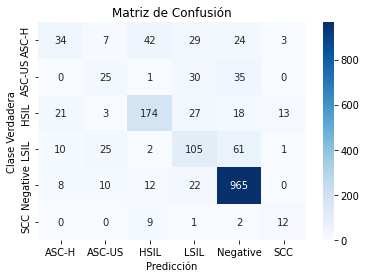

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step


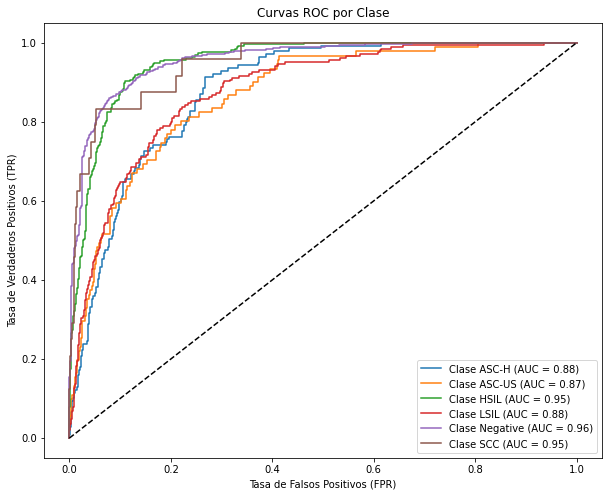

AUC Promedio: 0.91
AUC Promedio Ponderado: 0.94


In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')


## Modelo MobileNetV2

In [26]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

/var/folders/kl/780b8_9s0y35m4d8w8w07wfh0000gn/T/ipykernel_57554/770786427.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 20s 2us/step
Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.5579 - auc: 0.8341 - f1_score: 0.8341 - loss: 1.3104 - precision: 0.6972 - recall: 0.4441 - val_accuracy: 0.5948 - val_auc: 0.8178 - val_f1_score: 0.8178 - val_loss: 2.9942 - val_precision: 0.5977 - val_recall: 0.5925 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.7067 - auc: 0.9301 - f1_score: 0.9301 - loss: 0.8308 - precision: 0.8095 - recall: 0.5908 - val_accuracy: 0.6116 - val_auc: 0.8532 - val_f1_score: 0.8532 - val_loss: 2.1316 - val_precision: 0.6217 - val_recall: 0.6052 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7349 - auc: 0.9460 - f1_score: 0.9460 - loss: 0.7304 - precision: 0.8314 - recall: 0.6460 - val_accuracy: 0.7214 - val_auc: 0.9264 - val_f1_score: 0.9264 - val_loss: 0.9857 - val_precision: 0.7655 - val_recall: 0.6925 - learning_rate: 1.0000e-04
Epoch 4/

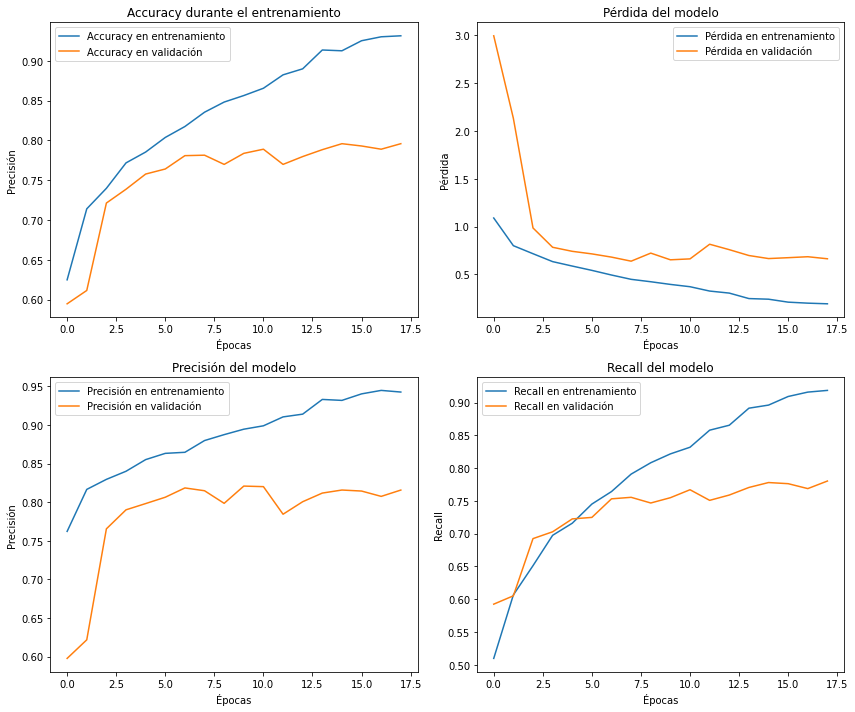

In [27]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [28]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6713 - auc: 0.9126 - f1_score: 0.9126 - loss: 1.0043 - precision: 0.6985 - recall: 0.6375
Pérdida en el conjunto de prueba: 0.6283866763114929
accuracy en el conjunto de prueba: 0.7943385243415833
Precision en el conjunto de prueba: 0.8226205110549927
Recall en el conjunto de prueba: 0.7689197063446045
AUC en el conjunto de prueba: 0.962430477142334
F1-Score en el conjunto de prueba: 0.962430477142334


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


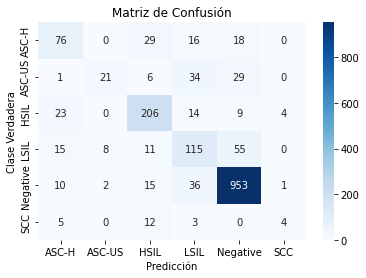

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

In [32]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.58      0.55      0.57       139
      ASC-US       0.68      0.23      0.34        91
        HSIL       0.74      0.80      0.77       256
        LSIL       0.53      0.56      0.55       204
    Negative       0.90      0.94      0.92      1017
         SCC       0.44      0.17      0.24        24

    accuracy                           0.79      1731
   macro avg       0.64      0.54      0.56      1731
weighted avg       0.79      0.79      0.78      1731



55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


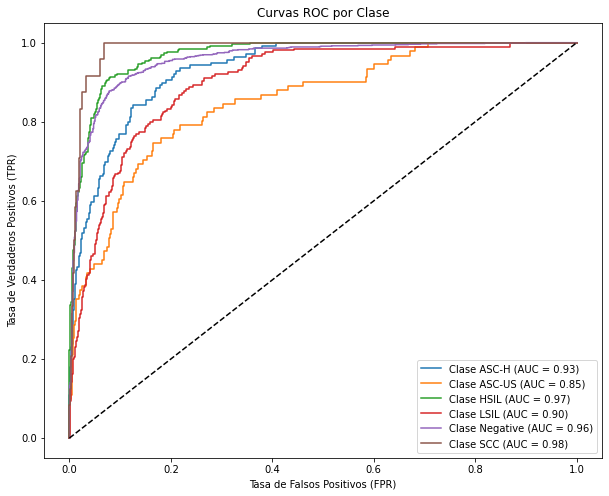

AUC Promedio: 0.93
AUC Promedio Ponderado: 0.95


In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

## Modelo MobileNetV3

In [37]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.5909 - auc: 0.8571 - f1_score: 0.8571 - loss: 1.1615 - precision: 0.7345 - recall: 0.4489 - val_accuracy: 0.5861 - val_auc: 0.8127 - val_f1_score: 0.8127 - val_loss: 1.4444 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.6782 - auc: 0.9140 - f1_score: 0.9140 - loss: 0.9203 - precision: 0.7946 - recall: 0.5497 - val_accuracy: 0.5879 - val_auc: 0.8159 - val_f1_score: 0.8159 - val_loss: 1.3220 - val_precision: 0.4000 - val_recall: 0.0058 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.6800 - auc: 0.9179 - f1_score: 0.9179 - loss: 0.8989 - precision: 0.7981 - recall: 0.5616 - val_accuracy: 0.5879 - val_auc: 0.8212 - val_f1_score: 0.8212 - val_loss: 1.2919 - val_precision: 0.5879 - val_recall: 0.5879 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/s

In [ ]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5005 - auc: 0.8368 - f1_score: 0.8368 - loss: 1.2913 - precision: 0.5257 - recall: 0.3870
Pérdida en el conjunto de prueba: 0.7424139976501465
accuracy en el conjunto de prueba: 0.7331022620201111
Precision en el conjunto de prueba: 0.802390992641449
Recall en el conjunto de prueba: 0.6591565608978271
AUC en el conjunto de prueba: 0.9468383193016052
F1-Score en el conjunto de prueba: 0.9468383193016052


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


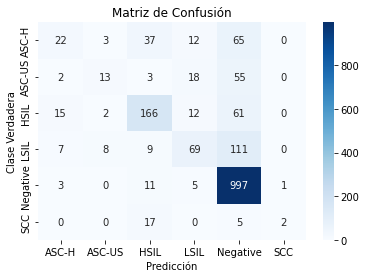

              precision    recall  f1-score   support

       ASC-H       0.45      0.16      0.23       139
      ASC-US       0.50      0.14      0.22        91
        HSIL       0.68      0.65      0.67       256
        LSIL       0.59      0.34      0.43       204
    Negative       0.77      0.98      0.86      1017
         SCC       0.67      0.08      0.15        24

    accuracy                           0.73      1731
   macro avg       0.61      0.39      0.43      1731
weighted avg       0.70      0.73      0.69      1731



In [40]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


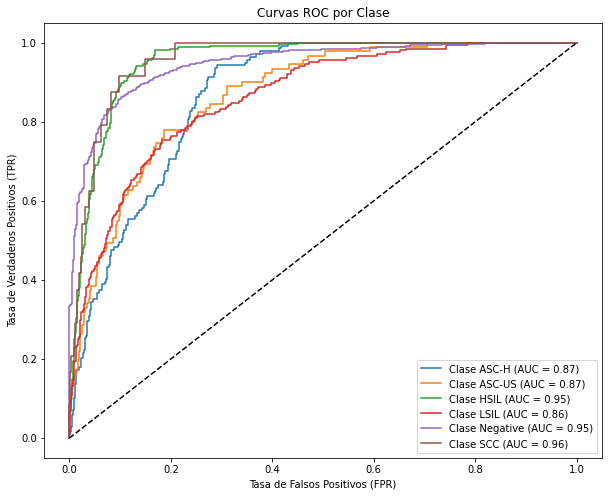

AUC Promedio: 0.91
AUC Promedio Ponderado: 0.93


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

## Modelo InceptionV3

In [43]:
# Importar y Definir el Modelo InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 60s 1us/step
Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - accuracy: 0.5588 - auc: 0.8273 - f1_score: 0.8273 - loss: 1.2665 - precision: 0.7172 - recall: 0.3595 - val_accuracy: 0.6936 - val_auc: 0.9229 - val_f1_score: 0.9229 - val_loss: 0.8802 - val_precision: 0.8356 - val_recall: 0.5728 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - accuracy: 0.6911 - auc: 0.9193 - f1_score: 0.9193 - loss: 0.8953 - precision: 0.8339 - recall: 0.5552 - val_accuracy: 0.7428 - val_auc: 0.9434 - val_f1_score: 0.9434 - val_loss: 0.7701 - val_precision: 0.8588 - val_recall: 0.6046 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.7357 - auc: 0.9433 - f1_score: 0.9433 - loss: 0.7517 - precision: 0.8464 - recall: 0.6285 - val_accuracy: 0.7630 - val_auc: 0.9545 - val_f1_score: 0.9545 - val_loss: 0.6738 - val_precision: 0.8574 - val_recall: 0.6671 - learning_rate: 1.0000e-04
Epo

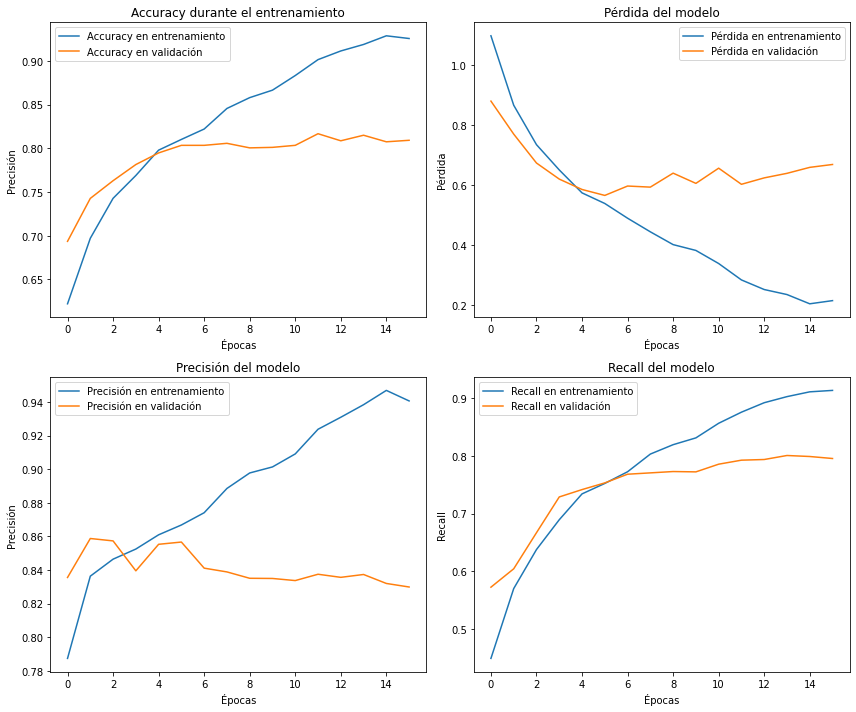

In [44]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [45]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6905 - auc: 0.9191 - f1_score: 0.9191 - loss: 0.9034 - precision: 0.7447 - recall: 0.6239
Pérdida en el conjunto de prueba: 0.5743588805198669
accuracy en el conjunto de prueba: 0.805314838886261
Precision en el conjunto de prueba: 0.8600525856018066
Recall en el conjunto de prueba: 0.7562102675437927
AUC en el conjunto de prueba: 0.9658884406089783
F1-Score en el conjunto de prueba: 0.9658884406089783


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step


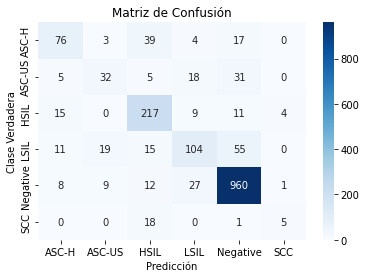

              precision    recall  f1-score   support

       ASC-H       0.66      0.55      0.60       139
      ASC-US       0.51      0.35      0.42        91
        HSIL       0.71      0.85      0.77       256
        LSIL       0.64      0.51      0.57       204
    Negative       0.89      0.94      0.92      1017
         SCC       0.50      0.21      0.29        24

    accuracy                           0.81      1731
   macro avg       0.65      0.57      0.59      1731
weighted avg       0.79      0.81      0.79      1731



In [46]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


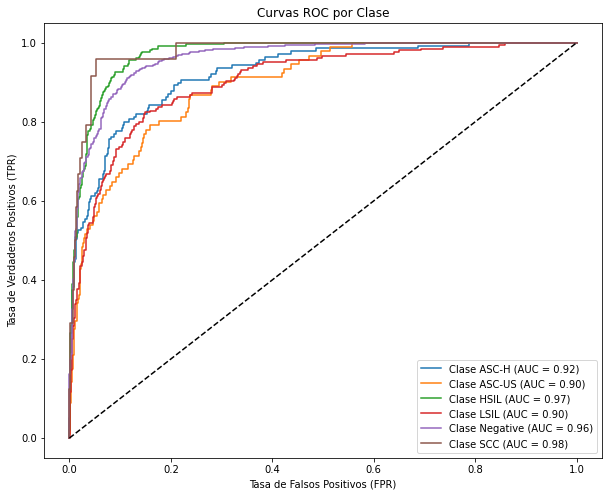

AUC Promedio: 0.94
AUC Promedio Ponderado: 0.95


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

## Modelo Xception

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Configuración de parámetros
IMG_HEIGHT, IMG_WIDTH = 90, 90
BATCH_SIZE = 32
NUM_CLASSES = len(train_generator.class_indices)

# Pesos de clase para manejar el desbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Cargar el modelo base Xception preentrenado en ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True  # Habilitamos el fine-tuning completo

# Congelar las primeras capas para evitar sobreajuste rápido
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Definir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.AUC(name='auc')]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,  # Aplicar los pesos de clase
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-29 23:45:47.446896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 8
2024-10-29 23:46:13.928146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-10-29 23:48:23.311458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-10-29 23:55:33.449012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDat

 24/253 ━━━━━━━━━━━━━━━━━━━━ 4:02:51 64s/step - accuracy: 0.3031 - auc: 0.6352 - loss: 1.8184 - precision: 0.3141 - recall: 0.0077

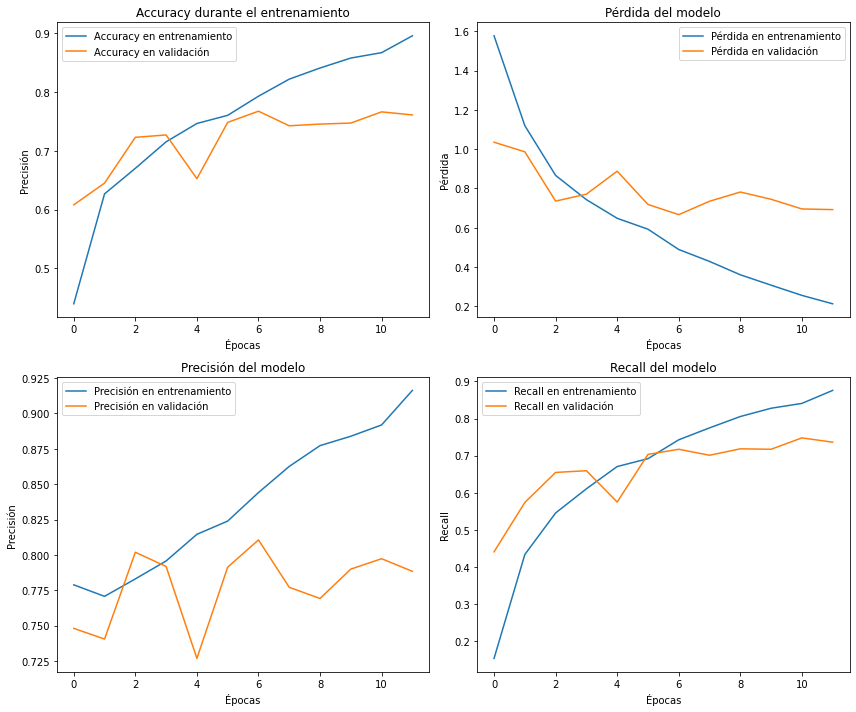

In [36]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [40]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.6781 - auc: 0.9292 - loss: 0.8827 - precision: 0.7088 - recall: 0.6381
Pérdida en el conjunto de prueba: 0.7139395475387573
accuracy en el conjunto de prueba: 0.7446562647819519
Precision en el conjunto de prueba: 0.7803468108177185
Recall en el conjunto de prueba: 0.7019063830375671
AUC en el conjunto de prueba: 0.9499239921569824


55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step


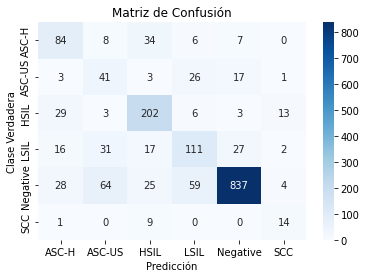

In [41]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

# Graficar la matriz de confusión con probabilidades
plot_confusion_matrix(cm_normalized, class_labels, title='Matriz de Confusión - Probabilidades', fmt='.2f')

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

# Modelos con balanceo de datos

In [54]:
import os
import numpy as np
import shutil
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorios
train_dir = 'crops_90x90_6clases/train'
output_balanced_dir = 'crops_90x90_6clases/train_balanced'
original_data_dir = 'crops_90x90'

# Clases
classes = ['Negative', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC']

# Crear el directorio de salida si no existe
if os.path.exists(output_balanced_dir):
    shutil.rmtree(output_balanced_dir)  # Eliminar si ya existe para evitar duplicados
os.makedirs(output_balanced_dir, exist_ok=True)

# Crear subcarpetas para cada clase en el directorio balanceado
for class_name in classes:
    os.makedirs(os.path.join(output_balanced_dir, class_name), exist_ok=True)

# Generador de datos con aumentación
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Verificar enlaces simbólicos rotos
def check_broken_symlinks(directory):
    """Verifica enlaces simbólicos rotos y los elimina."""
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if os.path.islink(file_path) and not os.path.exists(file_path):
                print(f"Enlace roto encontrado: {file_path}")
                os.remove(file_path)

# Ejecutar la verificación de enlaces rotos
check_broken_symlinks(train_dir)

# Crear enlaces simbólicos válidos si es necesario
def recreate_symlinks(source_dir, target_dir, classes):
    """Recrea enlaces simbólicos para cada clase."""
    for class_name in classes:
        source_class_dir = os.path.join(source_dir, class_name)
        target_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)

        for file in os.listdir(source_class_dir):
            source_path = os.path.join(source_class_dir, file)
            target_path = os.path.join(target_class_dir, file)
            if not os.path.exists(target_path):  # Solo crear si no existe
                os.symlink(source_path, target_path)

# Generar imágenes aumentadas y guardarlas
def generate_and_save_augmented_images(class_name, num_new_images):
    """Genera nuevas imágenes aumentadas para una clase específica."""
    generator = datagen.flow_from_directory(
        train_dir,
        target_size=(90, 90),
        batch_size=1,
        class_mode='categorical',
        shuffle=True,
        classes=[class_name]
    )
    save_dir = os.path.join(output_balanced_dir, class_name)

    # Generar y guardar nuevas imágenes
    for i in range(num_new_images):
        try:
            img, _ = next(generator)
            save_path = os.path.join(save_dir, f"augmented_{i}.png")
            img = np.squeeze(img, axis=0)  # Quitar la dimensión extra del batch
            img = (img * 255).astype(np.uint8)  # Escalar de vuelta a 0-255
            Image.fromarray(img).save(save_path)
        except (UnidentifiedImageError, IOError, FileNotFoundError) as e:
            print(f"Error al procesar una imagen: {e}")

# Generador de datos original para contar las clases
original_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    target_size=(90, 90),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Contar las imágenes por clase
class_counts = dict(zip(classes, [0] * len(classes)))
for i in range(len(original_generator.classes)):
    class_name = classes[original_generator.classes[i]]
    class_counts[class_name] += 1

print("Distribución de clases antes del balanceo:", class_counts)

# Incrementar un 50% las clases menos representadas (excepto la clase 'Negative')
INCREMENT_PERCENTAGE = 0.5

for class_name, count in class_counts.items():
    if class_name != 'Negative':  # No aumentar la clase mayoritaria
        num_new_images = int(count * INCREMENT_PERCENTAGE)
        if num_new_images > 0:
            print(f"Generando {num_new_images} imágenes para la clase {class_name}")
            generate_and_save_augmented_images(class_name, num_new_images)

# Verificar la nueva distribución después del balanceo
balanced_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    output_balanced_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='categorical'
)

# Contar las clases después del balanceo
new_class_counts = dict(zip(classes, [0] * len(classes)))
for i in range(len(balanced_generator.classes)):
    class_name = classes[balanced_generator.classes[i]]
    new_class_counts[class_name] += 1

print("Distribución de clases después del balanceo:", new_class_counts)

Found 8073 images belonging to 6 classes.
Distribución de clases antes del balanceo: {'Negative': 647, 'HSIL': 424, 'LSIL': 1192, 'ASC-H': 952, 'ASC-US': 4745, 'SCC': 113}
Generando 212 imágenes para la clase HSIL
Found 1192 images belonging to 1 classes.


KeyboardInterrupt: 